# Video Colorization with U-Net and GAN

In [ ]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
!pip install fastai==2.4
!gdown --id 1Mgvfb9BfIjmRH3G9ju0NHWhKOpvbF5mS # Perceptual Loss
!gdown --id 1l_KBj-pF67Zhhh7s1hNsEKP29Piz9dPD # Color network.py
!gdown --id 14F0uRMVwV1yGbvapo_sc-7eguKBzHoi7 # resnet-unet-epoch70
from loss import *
from color_network import *

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Mgvfb9BfIjmRH3G9ju0NHWhKOpvbF5mS
To: /content/loss.py
100% 4.80k/4.80k [00:00<00:00, 7.35MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1l_KBj-pF67Zhhh7s1hNsEKP29Piz9dPD
To: /content/color_network.py
100% 1.66k/1.66k [00:00<00:00, 2.68MB/s]


In [ ]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"

In [ ]:
paths = glob.glob(coco_path + "/*.jpg") 
np.random.seed(123)
paths_subset = np.random.choice(paths, 10000, replace=False) 
rand_idxs = np.random.permutation(10000)
train_idxs = rand_idxs[:8000] 
val_idxs = rand_idxs[8000:]
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


<h2>Making Datasets and DataLoaders

In [ ]:
class DATASET(Dataset):
    def __init__(self, paths, transform = None):
        self.transform = transform            
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32")
        L = img_lab[:,:,0] / 50. - 1.
        ab = img_lab[:,:,1:] / 110.
        L = transforms.ToTensor()(L)
        ab = transforms.ToTensor()(ab)  
                     
        return L, ab
    
    def __len__(self):
        return len(self.paths)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


  0%|          | 0/2000 [00:00<?, ?it/s]

torch.Size([1, 1, 720, 1280]) torch.Size([1, 2, 720, 1280])
250 2000


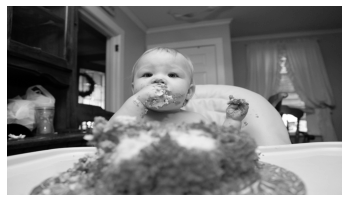

In [ ]:
transform = transforms.Compose([
                transforms.Resize((256, 256),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(),
            ])
dataset = DATASET(paths=train_paths, transform = transform)
train_loader = DataLoader(dataset, batch_size=32, num_workers=0, pin_memory=True)

dataset = DATASET(paths=val_paths, transform = transforms.Resize((720, 1280),  Image.BICUBIC))
val_loader = DataLoader(dataset, batch_size=1, num_workers=0, pin_memory=True)

for (dict_) in tqdm(val_loader):
    print(dict_[0].shape, dict_[1].shape)
    print(len(train_loader), len(val_loader))
    plt.axis(False)
    plt.imshow(dict_[0][0].squeeze(0),'gray')
    break

In [ ]:
print("Number of batches : ", len(train_loader), len(val_loader))
print("Number of datapoints : ", len(train_loader.dataset), len(val_loader.dataset))

Number of batches :  250 2000
Number of datapoints :  8000 2000


<h2>Pretraining the generator for colorization task

In [ ]:
net_G = Generator(n_input=1, n_output=2, size=256)
# net_G.load_state_dict(torch.load('../input/resnet/res18-unet-epoch-70.pt'))
optimizer = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()        
epochs = 50
max_train_loss = np.inf

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
for e in range(epochs):
    train_loss = 0
    for (data) in tqdm(train_loader):
        L, ab = data[0].to(device), data[1].to(device)
        preds = net_G(L)
        loss = criterion(preds, ab)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss =  train_loss/len(train_loader) 
    print(f"Epoch {e + 1}/{epochs}")
    print(f"L1 Loss: {train_loss:.5f}")
    if max_train_loss > train_loss:
        max_train_loss = train_loss
        print("Model Saved")
        torch.save(net_G.state_dict(), "./res18-unet.pt")
    

<h2>Training

In [ ]:
net_G = Generator(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("../input/net-generator/res18-unet.pt", map_location=device))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
net_D = PatchDiscriminator(in_channels = 3) 
net_D.to(device)    
print('Loaded model onto GPU.') 

Loaded model onto GPU.


In [ ]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

In [ ]:
opt_G = optim.Adam(net_G.parameters(), lr = 2e-4, betas = (0.5, 0.999))
opt_D = optim.Adam(net_D.parameters(), lr = 2e-4, betas = (0.5, 0.999))
max_train_loss = np.inf
epoch = 20

In [ ]:
net_G.train()
net_D.train()
lossg = []
lossd = []

for e in range(1, epoch+1):
    gan_loss=0.0
    g_loss_average = 0.0
    d_loss_average = 0.0
    for (L, ab) in tqdm(train_loader):

        L = L.to(device = device, dtype = torch.float32)
        ab = ab.to(device = device, dtype = torch.float32)
        out_ab = net_G(L) 

        fake = torch.cat([L, out_ab], dim = 1)
        color = torch.cat([L, ab], dim = 1)    

        # Train Discriminator
        D_real = net_D(color)
        D_fake = net_D(fake.detach()) 
        D_real_loss = criterion_BCE(D_real, torch.ones_like(D_real))
        D_fake_loss = criterion_BCE(D_fake, torch.zeros_like(D_fake))
        D_loss = (D_real_loss + D_fake_loss) / 2

        d_loss_average += D_loss.item()
        opt_D.zero_grad()
        D_loss.backward()
        opt_D.step()
    
        # Train generator        
        D_fake = net_D(fake) 

        G_bce_loss = criterion_BCE(D_fake, torch.ones_like(D_fake))
        gan_loss+=G_bce_loss
        G_l1_loss = criterion_L1(out_ab, ab)
        G_perceptual_loss = criterion_Perceptual(fake, color)

        G_loss = ((G_bce_loss*1) + (G_l1_loss*50.)) + (G_perceptual_loss*1)

        g_loss_average += G_loss.item()
        opt_G.zero_grad()
        G_loss.backward()
        opt_G.step()
        
    gan_loss_average = g_loss_average/len(train_loader)
    lossg.append(g_loss_average/len(train_loader))
    lossd.append(d_loss_average/len(train_loader))

    print(f"Epoch {e}:")
    print(f"Generator Loss: {g_loss_average/len(train_loader):.5f}")
    print(f"Discriminator Loss: {d_loss_average/len(train_loader):.5f}")
    print(f"Generator GAN Loss: {gan_loss/len(train_loader):.5f}")

    if max_train_loss > gan_loss_average:
        max_train_loss = gan_loss_average
        print("Model Saved")
        torch.save(net_G.state_dict(), "./net_G-final" )
        torch.save(net_D.state_dict(), "./net_D-final" )
    print("------------------------------------------------------------------------------------------------------\n")


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1:
Generator Loss: 3.84700
Discriminator Loss: 0.67214
Generator GAN Loss: 0.78247
Model Saved
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2:
Generator Loss: 3.63339
Discriminator Loss: 0.65588
Generator GAN Loss: 0.81992
Model Saved
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3:
Generator Loss: 3.49801
Discriminator Loss: 0.65349
Generator GAN Loss: 0.83704
Model Saved
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4:
Generator Loss: 3.43076
Discriminator Loss: 0.65200
Generator GAN Loss: 0.84037
Model Saved
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5:
Generator Loss: 3.38588
Discriminator Loss: 0.64998
Generator GAN Loss: 0.84900
Model Saved
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6:
Generator Loss: 3.35755
Discriminator Loss: 0.64851
Generator GAN Loss: 0.85367
Model Saved
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7:
Generator Loss: 3.29457
Discriminator Loss: 0.65816
Generator GAN Loss: 0.85213
Model Saved
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8:
Generator Loss: 3.23815
Discriminator Loss: 0.64802
Generator GAN Loss: 0.83578
Model Saved
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9:
Generator Loss: 3.21932
Discriminator Loss: 0.65001
Generator GAN Loss: 0.84603
Model Saved
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10:
Generator Loss: 3.20135
Discriminator Loss: 0.65008
Generator GAN Loss: 0.84936
Model Saved
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11:
Generator Loss: 3.16948
Discriminator Loss: 0.65040
Generator GAN Loss: 0.84784
Model Saved
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12:
Generator Loss: 3.14053
Discriminator Loss: 0.64944
Generator GAN Loss: 0.85036
Model Saved
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13:
Generator Loss: 3.11161
Discriminator Loss: 0.64864
Generator GAN Loss: 0.85054
Model Saved
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14:
Generator Loss: 3.09078
Discriminator Loss: 0.64955
Generator GAN Loss: 0.85108
Model Saved
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15:
Generator Loss: 3.06225
Discriminator Loss: 0.64860
Generator GAN Loss: 0.84956
Model Saved
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 16:
Generator Loss: 3.03641
Discriminator Loss: 0.66528
Generator GAN Loss: 0.85245
Model Saved
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17:
Generator Loss: 2.98249
Discriminator Loss: 0.64746
Generator GAN Loss: 0.82435
Model Saved
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 18:
Generator Loss: 2.98690
Discriminator Loss: 0.64803
Generator GAN Loss: 0.84256
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 19:
Generator Loss: 2.98426
Discriminator Loss: 0.65102
Generator GAN Loss: 0.84744
------------------------------------------------------------------------------------------------------



  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 20:
Generator Loss: 2.96938
Discriminator Loss: 0.64930
Generator GAN Loss: 0.84669
Model Saved
------------------------------------------------------------------------------------------------------



In [ ]:
import pandas as pd
df = pd.DataFrame({"Generator Loss" : lossg, "Discriminator Loss" : lossd})
df.to_csv("metrics.csv")

<h2>Visulizing Plots

In [ ]:
import pandas as pd
!gdown --id 1d2KBMJOkMIDLanupM1tNenVVfWXIiOxk
df = pd.read_csv("./metrics.csv")
def plot_2(x, y1, y2, x_label, y_label, y1_label, y2_label):
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, x + 1, 1), y1, marker='o', color = 'b', label = y1_label)
    plt.plot(np.arange(1, x + 1, 1), y2, marker='o', color = 'r', label = y2_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1d2KBMJOkMIDLanupM1tNenVVfWXIiOxk
To: /content/metrics.csv
100% 834/834 [00:00<00:00, 572kB/s]


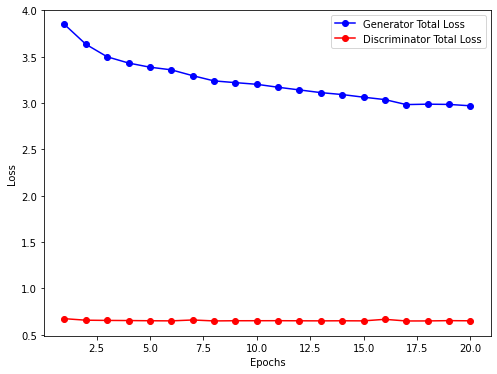

In [ ]:
plot_2(len(df), df['Generator Loss'], df['Discriminator Loss'], "Epochs", "Loss", "Generator Total Loss", "Discriminator Total Loss")

### 1.7- Visualizing Results

In [ ]:
!gdown --id 1KL1lpiYLWkn5WGKNunJeL4bpBuTQN2JP
model = Generator(n_input=1, n_output=2, size=256)
model.load_state_dict(torch.load("/content/net_G_unet_final.pt", map_location=device))

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1KL1lpiYLWkn5WGKNunJeL4bpBuTQN2JP
To: /content/net_G_unet_final.pt
100% 125M/125M [00:00<00:00, 202MB/s]


<All keys matched successfully>

In [ ]:
if __name__ == '__main__':
    print('Starting validation.')    
    # Switch model to validation mode
    model.eval()    
    for (gray, ab) in tqdm(val_loader):
        
        L = gray.to(device = device, dtype = torch.float32)
        ab = ab.to(device = device, dtype = torch.float32)
        output = model(L) 
        
        fake = torch.cat([L, output], dim = 1).detach().cpu().numpy()
        for i in range(fake.shape[0]):
            color_image = fake[i]
            color_image = color_image.transpose((1, 2, 0))
            color_image[:, :, 0:1] = (color_image[:, :, 0:1] + 1.)* 50.
            color_image[:, :, 1:3] = color_image[:, :, 1:3] * 110.
            color_image = lab2rgb(color_image.astype(np.float64))
            plt.axis(False)
            plt.imshow(color_image)
            plt.show()